In [1]:
# Load and Read the MINST Dataset:

import torch
from torchvision import datasets, transforms

# Assign the device to the GPU if available else use the CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load Training Dataset
train_data_set = datasets.MNIST(root='./mnist_data', train=True, transform=transforms.ToTensor())
train_data_loader = torch.utils.data.DataLoader(dataset=train_data_set, batch_size=1000, shuffle=True)

# Read the whole MINST training dataset in form of batches
examples = iter(train_data_loader)
X, y = next(examples)
for i in range(1,60):
  X_temp, y_temp = next(examples)
  X_temp = X_temp.to(device)
  y_temp = y_temp.to(device)
  X = X.to(device)
  y = y.to(device)
  X = torch.concat([X, X_temp])
  y = torch.concat([y, y_temp])

In [2]:
# Split and Preprocess the Dataset:

from sklearn.model_selection import train_test_split

# Split the Training Data into Training 80% and validation sets 20%
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Create a Tensor Dataset from X_train and y_train 
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)

# Create a DataLoader from the train_dataset
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)

# Create a Tensor Dataset from X_valid and y_valid 
valid_dataset = torch.utils.data.TensorDataset(X_valid, y_valid)

# Create a DataLoader from the valid_dataset
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=100, shuffle=False)

In [3]:
# Create the Neural Network Architecture:

import torch.nn as nn

# Neural Network architecture with two hidden layers
class Neural_Network(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Neural_Network, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, output_size)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
    def forward (self, X):
        out = self.l1(X)
        out = self.relu1(out)
        out = self.l2(out)
        out = self.relu2(out)
        out = self.l3(out)
        return out
    
# Create an object from the Neural Network model  
net = Neural_Network(input_size=784, hidden_size=100, output_size=10) # Input Size = 28*28 = 784

In [4]:
# Train the Model using SGD and Cross Entropy Loss:

import torch
import torch.nn as nn
from torchmetrics import Accuracy

epoches_num = 10

# Accuracy, Loss and Optimizer intialization for training
train_criterion = nn.CrossEntropyLoss()
train_optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
train_accuracy = Accuracy(task='multiclass', num_classes=10)

# Accuracy and Loss intialization for validating
valid_criterion = nn.CrossEntropyLoss()
valid_accuracy = Accuracy(task='multiclass', num_classes=10)

# Intialization of lists for plotting
training_loss = []
validation_loss = []
validation_accuracy = []
training_accuracy = []

# Training the Model with learning rate = 0.01 and batch size = 100
for epoch in range(epoches_num):
    t_loss = 0.0
    net.train()
    for i, (samples, labels) in enumerate(train_dataloader):
        samples = samples.reshape(-1, 28*28).to(device)  
        outputs = net(samples) # Compute predicted outputs by passing inputs to the model
        loss = train_criterion(outputs, labels) # Compute the loss between the model's predicted outputs and the true labels
        train_optimizer.zero_grad() # Reset gradients of the model parameters
        loss.backward() # Compute the gradients of the loss with respect to the model parameters
        train_optimizer.step() # Update the model parameters using the computed gradients
        t_loss += loss.item()  
        train_accuracy.update(outputs, labels) 
    training_loss.append(t_loss / len(train_dataloader)) # Compute the average training loss for this epoch
    training_accuracy.append(train_accuracy.compute())  # Compute the training accuracy for this epoch
    train_accuracy.reset() 

    # Validate the model after each epoch
    v_loss = 0.0
    net.eval()
    for i, (samples, labels) in enumerate(valid_dataloader):
        samples = samples.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = net(samples)
        loss = valid_criterion(outputs, labels)
        v_loss += loss.item()
        valid_accuracy.update(outputs, labels)
    validation_loss.append(v_loss / len(valid_dataloader))
    validation_accuracy.append(valid_accuracy.compute())
    valid_accuracy.reset()
    

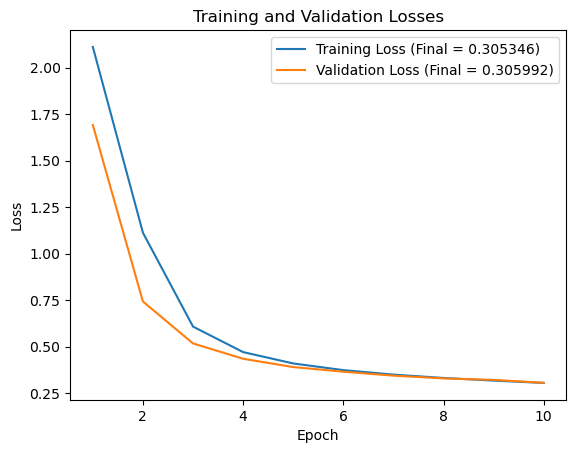

In [5]:
# PLot the Training and Validation Loss:

import matplotlib.pyplot as plt

epoches = list(range (1, epoches_num+1))
plt.plot(epoches, training_loss, label=f'Training Loss (Final = {training_loss[-1]:4f})')
plt.plot(epoches, validation_loss, label=f'Validation Loss (Final = {validation_loss[-1]:4f})')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


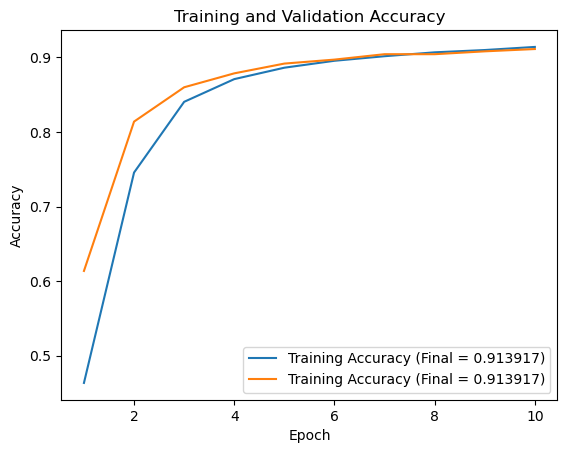

In [6]:
# PLot the Training and Validation Accuracy:

import matplotlib.pyplot as plt

epoches = list(range (1, epoches_num+1))
plt.plot(epoches, training_accuracy, label=f'Training Accuracy (Final = {training_accuracy[-1]:4f})')
plt.plot(epoches, validation_accuracy, label=f'Training Accuracy (Final = {training_accuracy[-1]:4f})')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


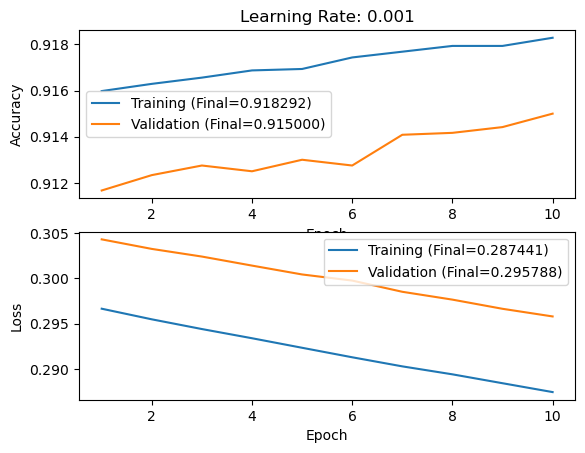

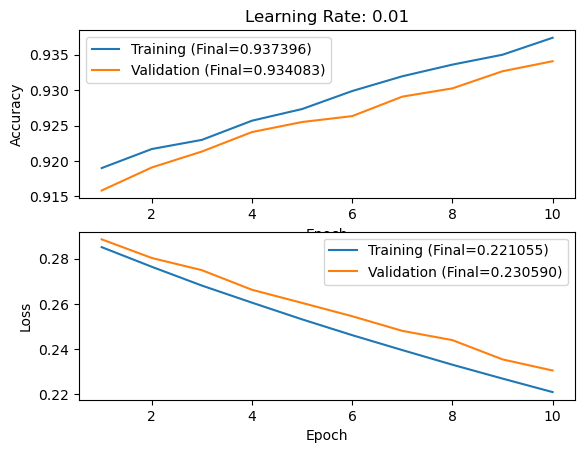

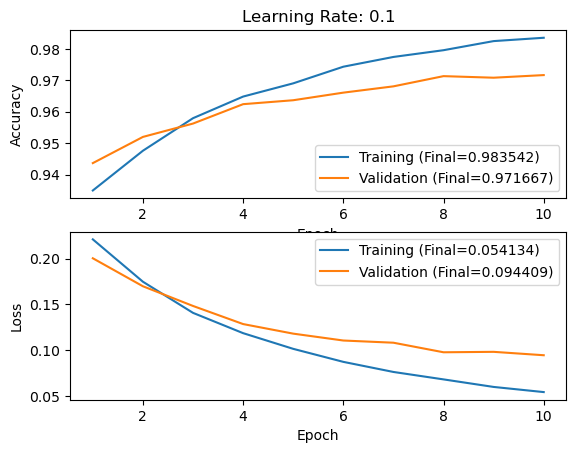

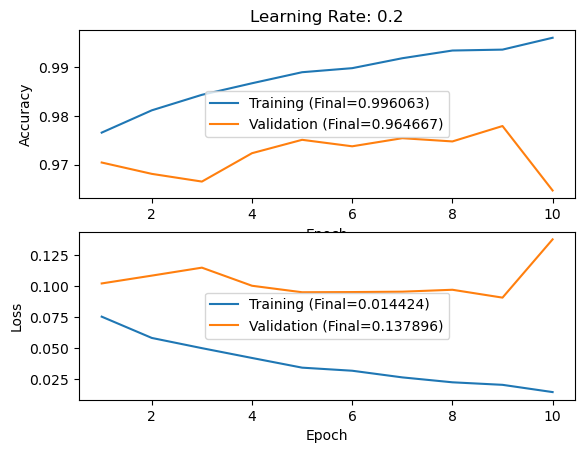

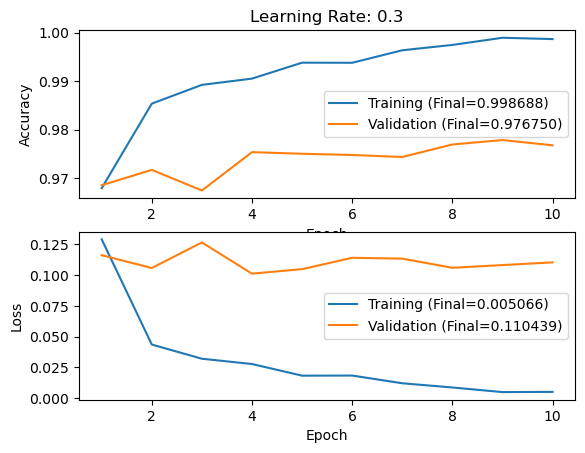

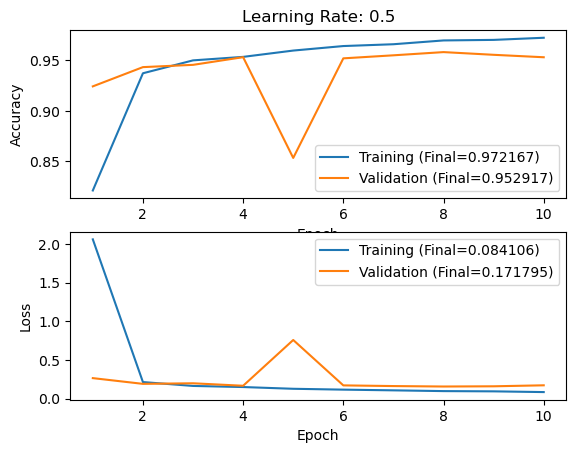

Maximum Validation Accuracy = 0.976750 at Learning Rate = 0.3
Minimum Validation Loss = 0.094409 at Learning Rate = 0.1


In [7]:
# Analysis of the Model by changing the Learning Rate

import torch
import torch.nn as nn
from torchmetrics import Accuracy
import matplotlib.pyplot as plt
import numpy as np

epoches_num = 10

# Accuracy and Loss initalization for Training and Validating the model
criterion = nn.CrossEntropyLoss()
accuracy_t = Accuracy(task='multiclass', num_classes=10)
accuracy_v = Accuracy(task='multiclass', num_classes=10)

# Intitalize lists for plotting
accuracy_list_t = []
accuracy_list_v = []
loss_list_t = []
loss_list_v = []
final_acc_v = []
final_loss_v = []

# Different Learning Rates to loop on
learning_rates = [0.001, 0.01, 0.1, 0.2, 0.3, 0.5]

epoches = list(range (1, epoches_num+1))

for j in range(len(learning_rates)):
    # Intialize the optimizer according to the learning rate
    net.train()
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rates[j])
    for epoch in range(epoches_num):
        total_loss_t = 0.0
        # Training 
        for i, (samples, labels) in enumerate(train_dataloader):
            samples = samples.reshape(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = net(samples)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step() 
            total_loss_t += loss.item()
            accuracy_t.update(outputs, labels)
        loss_list_t.append(total_loss_t / len(train_dataloader))
        accuracy_list_t.append(accuracy_t.compute())
        accuracy_t.reset()

        # Validating
        total_loss_v = 0.0
        net.eval()
        for i, (samples, labels) in enumerate(valid_dataloader):
            samples = samples.reshape(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = net(samples)
            loss = criterion(outputs, labels)
            total_loss_v += loss.item()
            accuracy_v.update(outputs, labels)
        loss_list_v.append(total_loss_v / len(valid_dataloader))
        accuracy_list_v.append(accuracy_v.compute())
        accuracy_v.reset()

    # Plot the Training and Validation Losses and Accuracy for different learning rates
    final_acc_v.append(accuracy_list_v[-1])
    final_loss_v.append(loss_list_v[-1])
    plt.subplot(2,1,1)
    plt.plot(epoches, accuracy_list_t, label=f'Training (Final={accuracy_list_t[-1]:4f})')
    plt.plot(epoches, accuracy_list_v, label=f'Validation (Final={accuracy_list_v[-1]:4f})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Learning Rate: {learning_rates[j]}')
    plt.legend()
    plt.subplot(2,1,2)
    plt.plot(epoches, loss_list_t, label=f'Training (Final={loss_list_t[-1]:4f})')
    plt.plot(epoches, loss_list_v, label=f'Validation (Final={loss_list_v[-1]:4f})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    accuracy_list_t = []
    accuracy_list_v = []
    loss_list_t = []
    loss_list_v = []

# Print the Max Validation Accuracy and the Min Validation Loss
max_accuracy = np.array(final_acc_v).argmax()
min_loss = np.array(final_loss_v).argmin()
print(f'Maximum Validation Accuracy = {final_acc_v[max_accuracy]:4f} at Learning Rate = {learning_rates[max_accuracy]}')
print(f'Minimum Validation Loss = {final_loss_v[min_loss]:4f} at Learning Rate = {learning_rates[min_loss]}')




Analysis for different learning rate Plots:
- learning rate = 0.001 is too small so the curve didn't converges yet.
- learning rates = 0.2, 0.3 and 0.5 overfits, as the validation converges earlier than training.
- learning rate = 0.01 is good but validation converges a bit earlier than training. 
- learning rate = 0.1 is the best as it has the least final validation loss and trainig and validation converges together.

General Insights:
- On increasing the learning rate, the Accuracy of the Model increases and its Loss decreases.
- Although, on increasing the learning rate alot the model may overshoot the optimal solution and fail to converge it.
- Moreover, at very small learning rates the model takes a long time to converge to a good soltuion because each update to the model is very small.

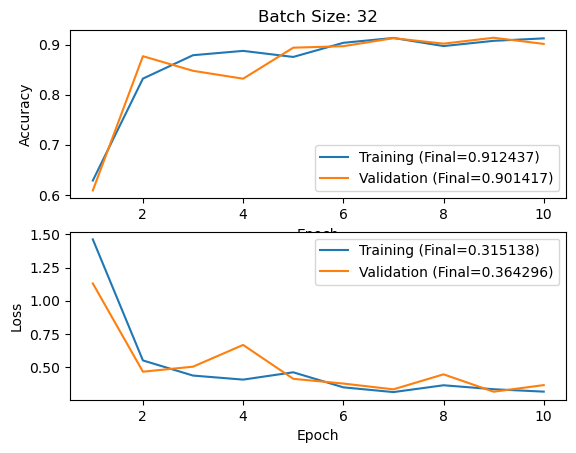

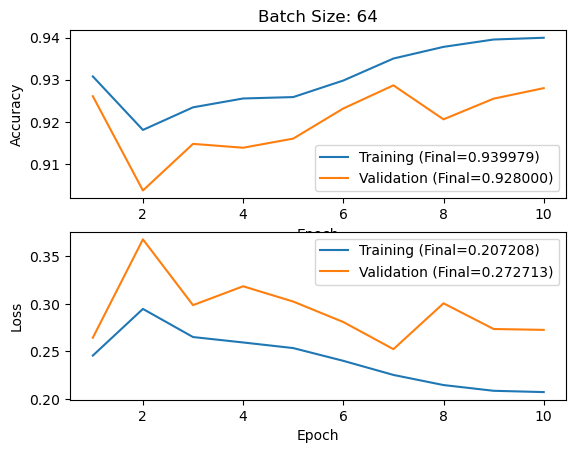

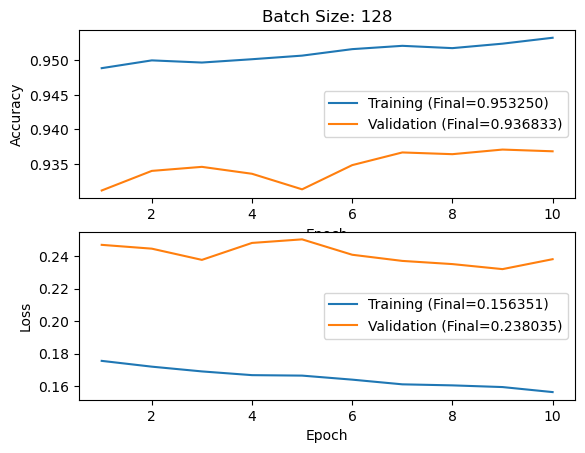

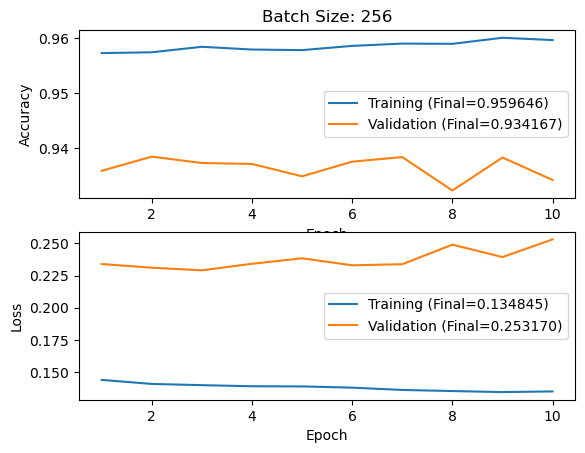

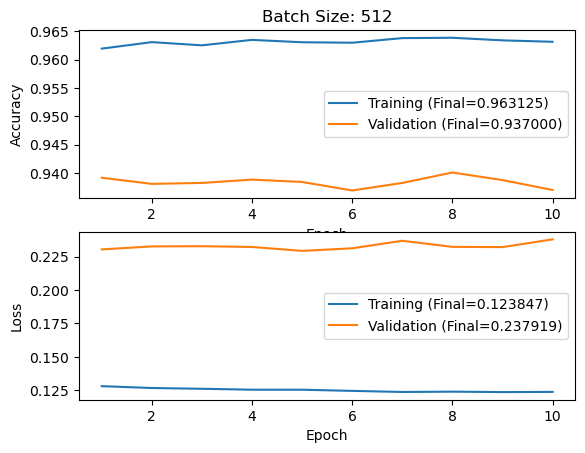

Maximum Validation Accuracy = 0.937000 at Learning Rate = 512
Minimum Validation Loss = 0.237919 at Learning Rate = 512


In [10]:
# Analysis of the Model by changing the Batch Size

import torch
import torch.nn as nn
from torchmetrics import Accuracy
import matplotlib.pyplot as plt
import numpy as np

epoches_num = 10

# Loss and accuracy intitalization for training and validating
criterion = nn.CrossEntropyLoss()
accuracy_bs_t = Accuracy(task='multiclass', num_classes=10)
accuracy_bs_v = Accuracy(task='multiclass', num_classes=10)

# intialize lists for plotting
accuracy_list_bs_t = []
accuracy_list_bs_v = []
loss_list_bs_t = []
loss_list_bs_v = []
final_acc_bs_v = []
final_loss_bs_v = []

# Different values of Batch size to loop on
batch_sizes = [32, 64, 128, 256, 512]

epoches = list(range (1, epoches_num+1))

for j in range(len(batch_sizes)):
    net.train()
    # Data Loaders for Training and Validation according to the batch size
    dataloader_t = torch.utils.data.DataLoader(train_dataset, batch_size=batch_sizes[j], shuffle=True) 
    dataloader_v = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_sizes[j], shuffle=False)
    # Optimizer intialization with the best learning rate (detected above) for training
    opt = torch.optim.SGD(net.parameters(), lr=0.5) 
    for epoch in range(epoches_num):
        total_loss_bs_t = 0.0
        for i, (samples, labels) in enumerate(dataloader_t):
            samples = samples.reshape(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = net(samples)
            loss = criterion(outputs, labels)
            opt.zero_grad()
            loss.backward()
            opt.step() 
            total_loss_bs_t += loss.item()
            accuracy_bs_t.update(outputs, labels)
        loss_list_bs_t.append(total_loss_bs_t / len(dataloader_t))
        accuracy_list_bs_t.append(accuracy_bs_t.compute())
        accuracy_bs_t.reset()

        total_loss_bs_v = 0.0
        net.eval()
        for i, (samples, labels) in enumerate(dataloader_v):
            samples = samples.reshape(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = net(samples)
            loss = criterion(outputs, labels)
            total_loss_bs_v += loss.item()
            accuracy_bs_v.update(outputs, labels)
        loss_list_bs_v.append(total_loss_bs_v / len(dataloader_v))
        accuracy_list_bs_v.append(accuracy_bs_v.compute())
        accuracy_bs_v.reset()

    # Plot the Training and Validation Losses and Accuracy for different batch sizes
    final_acc_bs_v.append(accuracy_list_bs_v[-1])
    final_loss_bs_v.append(loss_list_bs_v[-1])    
    plt.subplot(2,1,1)
    plt.plot(epoches, accuracy_list_bs_t, label=f'Training (Final={accuracy_list_bs_t[-1]:4f})')
    plt.plot(epoches, accuracy_list_bs_v, label=f'Validation (Final={accuracy_list_bs_v[-1]:4f})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Batch Size: {batch_sizes[j]}')
    plt.legend()
    plt.subplot(2,1,2)
    plt.plot(epoches, loss_list_bs_t, label=f'Training (Final={loss_list_bs_t[-1]:4f})')
    plt.plot(epoches, loss_list_bs_v, label=f'Validation (Final={loss_list_bs_v[-1]:4f})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    accuracy_list_bs_t = []
    accuracy_list_bs_v = []
    loss_list_bs_t = []
    loss_list_bs_v = []

# Print the Max Validation Accuracy and the Min Validation Loss
max_accuracy_bs = np.array(final_acc_bs_v).argmax()
min_loss_bs = np.array(final_loss_bs_v).argmin()
print(f'Maximum Validation Accuracy = {final_acc_bs_v[max_accuracy_bs]:4f} at Learning Rate = {batch_sizes[max_accuracy_bs]}')
print(f'Minimum Validation Loss = {final_loss_bs_v[min_loss_bs]:4f} at Learning Rate = {batch_sizes[min_loss_bs]}')


Analysis for different batch size:
- On increasing the batch size, the Accuracy incrrease and the loss decrease, the best batch size is 512.
- While batch size = 32 has a high validation loss and low validation accuracy.

General Insights:
- On increasing the batch size, the training process becomes faster because this allows the model to process more data at a time.
- On increasing the batch size, the accuracy may decrease because they could provide a less accurate estimation of the data.
- On the other hand, larger batch size leads to lower loss, which appears clearly with btach size = 512.

In [13]:
# Final Test using Test Dataset 

import torch
import torch.nn as nn
from torchmetrics import Accuracy
from torchvision import datasets, transforms

epoches_num = 10

# Load Test Dataset with batch size = 512
test_data_set = datasets.MNIST(root='./mnist_data', train=False, transform=transforms.ToTensor())
test_data_loader = torch.utils.data.DataLoader(dataset=test_data_set, batch_size=512, shuffle=False)

# Accuracy, Loss and Optimizer intialization for testing
test_criterion = nn.CrossEntropyLoss()
test_accuracy = Accuracy(task='multiclass', num_classes=10)

for epoch in range(epoches_num):
    # Test the Model
    tt_loss = 0.0
    net.eval()
    for i, (samples, labels) in enumerate(test_data_loader):
        samples = samples.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = net(samples)
        loss = valid_criterion(outputs, labels)
        tt_loss += loss.item()
        test_accuracy.update(outputs, labels)
    Av_loss = tt_loss / len(test_data_loader)
    test_acc = test_accuracy.compute()
print(f'Test Accuracy = {test_acc:4f}')
print(f'Test Loss = {Av_loss:4f}')




Test Accuracy = 0.944600
Test Loss = 0.209525
